In [2]:
from tensorflow import keras
import tensorflow as tf 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import seaborn as sn
import os
import cv2
import imghdr

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

1.REMOVE USELESS FILE TYPES 

In [5]:
import os
import cv2
import imghdr

from pathlib import Path

# data_dir = Path(r"C:\\Users\\AdrianKurzac(261404)\\Documents\\GitHub\\ImageClassification")
data_dir = Path(r"C:\\Users\\AdrianKurzac(261404)\\Documents\\GitHub\\PYTHON_KURSY\\python\\Jupyter_nauka\\Projekty\\6_DL_Image_HAppy_Sad\\data")
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    class_dir = data_dir / image_class
    if class_dir.is_dir():  # Upewnij się, że ścieżka jest katalogiem
        for image in os.listdir(class_dir):
            image_path = class_dir / image
            try:
                img = cv2.imread(str(image_path))  # Konwertuj na str, ponieważ pathlib.Path nie jest obsługiwany bezpośrednio przez cv2.imread()
                tip = imghdr.what(str(image_path))  # Konwertuj na str
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(str(image_path))
            except Exception as e:
                print('Issue with image {}'.format(image_path))
                # os.remove(str(image_path))  # Jeśli chcesz usuwać pliki, odkomentuj tę linię


2.LOAD DATA

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data')#ładujemy dane i ustawiamy je w klasach zaleznych od folderow

Found 136 files belonging to 2 classes.


In [ ]:
data_iterator =data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[1]#0 i 1 reprezentuja jedna z klas happy czy sad

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

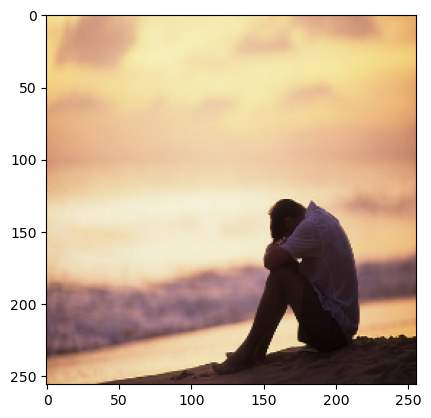

In [ ]:

img  = batch[0][5]# z tego wiem ze jedynki oznaczaja klase sad: 1==SAD
plt.imshow(img.astype(int))

Wgranie zdjecia

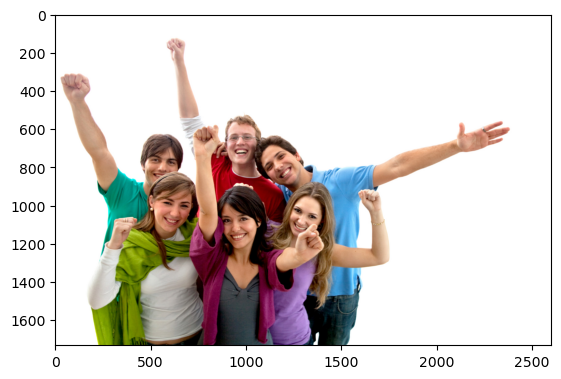

In [ ]:
img = cv2.imread("C:\\Users\\AdrianKurzac(261404)\\Documents\\GitHub\\PYTHON_KURSY\\python\\Jupyter_nauka\\Projekty\\6_DL_Image_HAppy_Sad\\data\\happy\\8cxKy5g9i.jpg")
img.shape
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.imshow(img)

3.Preprocess DATA

Scale data

In [ ]:
data = data.map(lambda x,y: (x/255,y))
scaled_iterator = data.as_numpy_iterator()


In [ ]:
batch = scaled_iterator.next()

In [ ]:
batch[0].min()

0.0

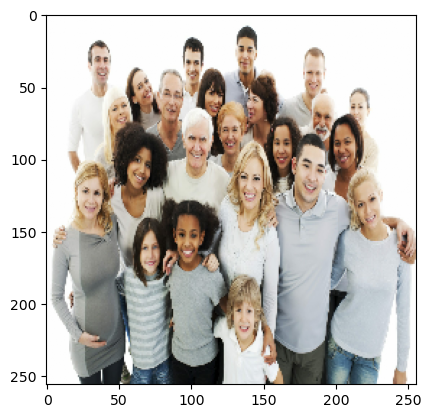

In [ ]:
img  = batch[0][5]# z tego wiem ze jedynki oznaczaja klase sad: 1==SAD

plt.imshow(img)


4.SPLIT DATA FOR TRAINING

In [ ]:
a = len(data)
a

5

In [ ]:
train_size = int(a*0.7)
train_size

3

In [ ]:
valid_size = int(a*0.2)
valid_size

1

In [ ]:
test_size = int(a*0.1)+1
test_size

1

In [ ]:
train = data.take(train_size)
valid = data.skip(train_size).take(valid_size)
test = data.skip(train_size+valid_size).take(test_size)

In [ ]:
len(test)

1

5.BUILD DEEP LEARNING MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
#na pierwszej warstwie mamy warstwe input, wartosc 16 mowi o ilosci filtrów wzgledem jakich oceniany jest obraz (3,3) okno do sprawdzania
# 1 mowi o przeskakiwaniu okna o jeden pixel, aktywacja relu usuwa wartosci mniejsze od 0 a wieksze zostawia bez zmian
# Conv2D(ilosc filtrow, wielkosc okna do filtrowania, skok okna, funkcja aktywacyjna)
#funkcja MaxPooling2D zmniejsza ilosc informacji ze zdjecia
model.add(Conv2D(16,(3,3),1,activation ='relu',input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation ='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation ='relu'))
model.add(MaxPooling2D())

#przed warstwa wyjsciowa dodajemy splaszczenie naszej funkcji
model.add(Flatten())

model.add(Dense(256,activation ='relu'))
#dostaniemy dzieki funkcji sigmoid 0 albo 1, jesli 0 to HAPPY jesli 1 to SAD
model.add(Dense(1,activation = 'sigmoid'))

In [ ]:
#adam to optimizer funkcja strat w tym przypadku jest binarycrossentropy bo 2 klasy i interesuje nas dokladnosc
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

6.TRAIN MODEL

In [ ]:
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
hist = model.fit(train,epochs=20,validation_data=valid,callbacks=[tensorboard_callback])

Epoch 1/20


3/3 [==============================] - 3s 673ms/step - loss: 1.1460 - accuracy: 0.4062 - val_loss: 0.8044 - val_accuracy: 0.4375
Epoch 2/20
3/3 [==============================] - 2s 637ms/step - loss: 0.7234 - accuracy: 0.5312 - val_loss: 0.6690 - val_accuracy: 0.5312
Epoch 3/20
3/3 [==============================] - 2s 631ms/step - loss: 0.6528 - accuracy: 0.5833 - val_loss: 0.5726 - val_accuracy: 0.7500
Epoch 4/20
3/3 [==============================] - 2s 630ms/step - loss: 0.6165 - accuracy: 0.6042 - val_loss: 0.7719 - val_accuracy: 0.4375
Epoch 5/20
3/3 [==============================] - 2s 632ms/step - loss: 0.5777 - accuracy: 0.6667 - val_loss: 0.6141 - val_accuracy: 0.6875
Epoch 6/20
3/3 [==============================] - 2s 629ms/step - loss: 0.5776 - accuracy: 0.6979 - val_loss: 0.5619 - val_accuracy: 0.5938
Epoch 7/20
3/3 [==============================] - 2s 627ms/step - loss: 0.5176 - accuracy: 0.6354 - val_loss: 0.5894 - val_accuracy: 0.5312
Epoch 8/20
3/3 [===============

In [ ]:
# hist.history

7.PLOT PERFORMANCE

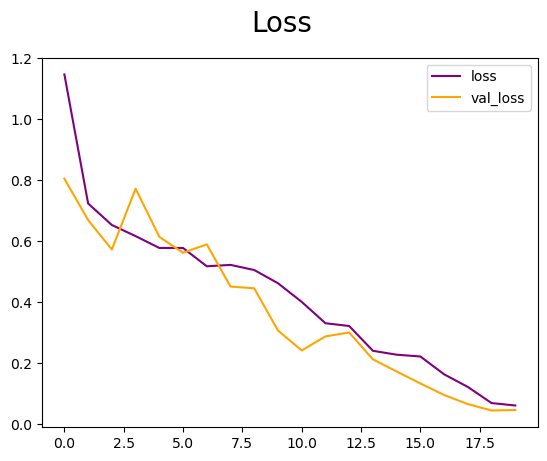

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='purple',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize = 20)
plt.legend()
plt.show()


8.EVALUETE

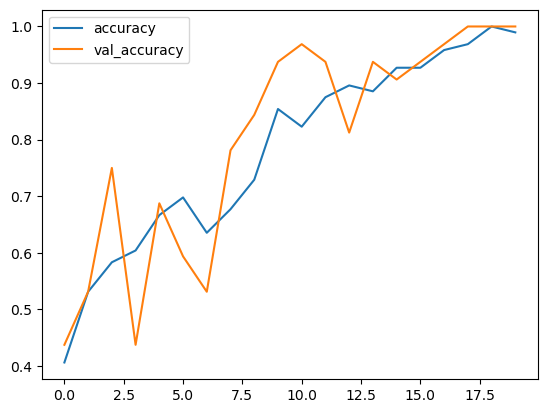

In [ ]:
plt.plot(hist.history['accuracy'],label = 'accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
fig.suptitle("Acurracy",fontsize=20)
plt.legend()
plt.show()

9. EVALUETE

In [ ]:
from tensorflow.keras.metrics import Precision,Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)



1/1 [==============================] - 0s 28ms/step


In [ ]:
print('Precision',pre.result().numpy(),'Recall',re.result().numpy(),'Accuracy',acc.result().numpy())

Precision 1.0 Recall 1.0 Accuracy 1.0


In [ ]:
img = cv2.imread('smileee.png')
plt.imshow(img,cv2.COLOR_BGR2RGB)

NameError: name 'cv2' is not defined